In [1]:
using Plots, Random, StatsBase

# Algoritmo Genético Simple

Implementar el esquema visto en clase del Algoritmo Genético Simple para maximizar funciones de dos variables considerando los siguientes puntos

* Representación de los individuos: cadenas de bits
* Inicialización de la población: a través de un generador de números pseudo-aleatorios.
* Tamaño de la población: constante
* Condición de término: Dos opciones
    * Número fijo de generaciones
    * Cuando ya no haya mejoría de los individuos
* Mecanismo de selección: Proporicional a su aptitud (ruleta)
* Recombinación: 1-crossover
* Mutación: bitflip, misma probabilidad para todo el genotipo
* Operador de reemplazo: generacional, es decir, se renueva toda la población en la siguiente generación

Para encontrar el **máximo global** de la **función de Schwefel $f(\vec{x})$** para $d = 2$ en el intervalo $(-500, 500)^{2}$.

\begin{equation}
  f(x_{1}, \dots, x_{d}) = \sum_{i = 1}^{d}{x_{i}\sin{(\sqrt{|x_{i}|})}}
\end{equation}

Las soluciones deberán tener al menos seis decimalies de precisión.

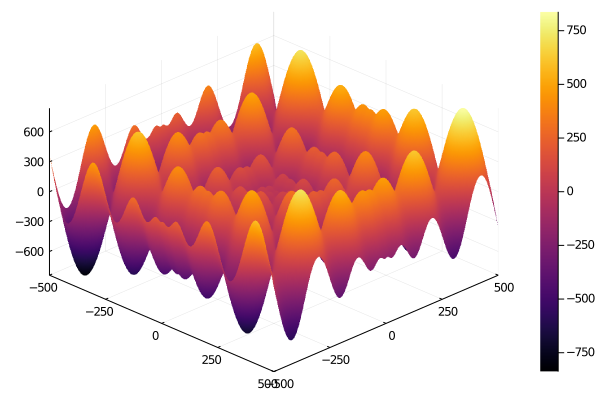

In [2]:
# definiendo la funciónde Schwefel
f(x::Array{Float64, 1})::Float64 = sum(@. x * sin(sqrt(abs(x))))

x = range(-500, 500, step=1.0)
y = range(-500, 500, step=1.0)

plot(x, y, (x, y)->f([x, y]), seriestype=:surface, camera=(45, 60))

## Modelación

### Genotipo y fenotipo

Cada coordenada se va a representar como una cadena de bits. Para esto, se usará codificación de punto fijo, donde la parte entera siempre se toma como 0, es decir que todos los números están entre 0 y 1. En esta, cada bit representa una potencia negativa de dos. En general, para obtener el número que representa la cadena $s$ con $n$ bits se usa la siguiente decodificación

\begin{equation}
    s_{num} = \sum_{i = 1}^{n}{2^{-i}s_{i}}
\end{equation}

Por ejemplo, la cadena $1010$ representa el siguiente número

\begin{equation}
    1010 \to 1\cdot 2^{-1} + 0 \cdot 2^{-2} + 1 \cdot 2^{-3} + 0 \cdot 2^{-4} = 0.5 + 0 + 0.125 + 0 = 0.625
\end{equation}


In [3]:
function from_fixed(x::String)::Float64
    res::Float64 = 0
    chars = split(x, "")
    for (i, d) in enumerate(chars)
        if d == "1"
            res += 2.0^(-i)
        end
    end
    return res
end

from_fixed (generic function with 1 method)

Luego, para tener una presición a seis decimales se requiere que el error en la codificación sea menor a $10^{-6}$. Es decir

\begin{equation}
    2^{-n} < 10^{-6} \implies -n < \log_{2}{10^{-6}} \implies n > \log_{2}{10^{6}}
\end{equation}

donde $n$ es la cantidad de bits en la cadena.

In [4]:
log2(10^6)

19.931568569324174

Por lo que cada número será una cadena de 20 bits. Así que la representación final del individuo será una cadena de 40 bits, 20 por cada cordenada.

In [5]:
const Solution = String

function to_coords(s::Solution; c_size::Int=20, dim::Int=2)::Array{Float64, 1}
    res = []
    for i in 1:dim
        low = (i-1)*c_size+1
        high = i*c_size
        xi = s[low:high]
        push!(res, from_fixed(xi))
    end
    return res
end

to_coords (generic function with 1 method)

### Aptitud

Las soluciones representan vectores con entradas estre 0 y 1. Para explorar el espacio de $(-500, 500)^{2}$, habría que mapear $0$ a $-500$ y $1$ a $500$ para cada entrada. Para la entrada $x$, esto se puede representar como $s(x) = 1000x - 500$.

Como se quiere maximizar la función, la evaluación de la función objetivo se puede usar como aptitud. Así que para obtener la aptitud de una solución, basta con decidificarla, escalarla y evaluarla en la función objetivo.

In [6]:
s(x::Float64, scale=500) = 2*scale*x - scale
apt(x::Solution) = 1000 + f(s.(to_coords(x)))

apt (generic function with 1 method)

### Reproducción

Primero, hay que definir una estructutura que guarde todos los parmámetros necesarios para el algoritmo genético.

Para el operador de selección, se toman dos padres con probabilidad proporcional a su aptitud.

In [20]:
function selection(s::Sga)::Solution
    apts = [apt(s) for s in s.pop]
    tot_apt = sum(apts)
    r = rand(s.rng)
    cum_apt = 0
    for i in 1:length(apts)
        cum_apt += apts[i]
        if cum_apt > r * tot_apt
            return s.pop[i]
        end
    end
    return last(s.pop)
end

selection (generic function with 1 method)

Para cruzar, con cierta probabilidad se va a elegir un punto de corte al azar, y se combinarán las dos secciones restantes para formar dos nuevas soluciones.

In [21]:
function cross(sga::Sga, s::Tuple{Solution, Solution})::Tuple{Solution, Solution}
    if rand.(sga.rng) < sga.cross_p
        s_size = length(s[1])
        b_point = rand(sga.rng, 1:s_size)
        n_s1 = s[1][1:b_point] * s[2][(b_point+1):s_size]
        n_s2 = s[2][1:b_point] * s[1][(b_point+1):s_size]
        return (n_s1, n_s2)
    end
    return s
end

cross (generic function with 1 method)

Para las mutaciones, simplemente se invierte un bit con cierta probabilidad.

In [22]:
function mutation(sga::Sga, s::Solution)::Solution
    n_s = ""
    for i in 1:length(s)
        if rand(sga.rng) < sga.mut_p
            n_s *= (s[i] == '1') ? '0' : '1'
        else
            n_s *= s[i]
        end
    end
    return n_s
end

mutation (generic function with 1 method)

Se reemplaza completamente la población.

In [23]:
function replacement(s::Sga)::Population
    n_pop = []
    while length(n_pop) < length(s.pop)
        p1 = selection(s)
        p2 = selection(s)
        n_s = cross(s, (p1, p2))
        m_s1 = mutation(s, n_s[1])
        push!(n_pop, m_s1)
        m_s2 = mutation(s, n_s[2])
        push!(n_pop, m_s2)
    end
    return n_pop
end

replacement (generic function with 1 method)

Para correr directamente el algoritmo genético, se reemplaza la población cierta cantidad de veces y se obtiene la mejor solución al final.

In [24]:
function run(s::Sga, gens::Int)::Solution
    for i in 1:gens
        s.pop = replacement(s)
    end
    apts = [apt(s) for s in s.pop]
    i = argmax(apts)
    return s.pop[i]
end

run (generic function with 1 method)

## Simulación

Establezca una población fija de 100 individuos, con tasa de recombinación en $pc = 0.5$, tasa de mutación $pm = 0.1$ y condición de término al finalizar 500 generaciones.

* ¿Cuál fue el mejor individuo? Reporte la estrcutura del genotipo, fenotipo y fitness. ¿Es el máximo global?

In [13]:
k = Sga(100, 0.5, 0.1)
best = run(k, 500)
print("genotipo: ", best, "\n")
print("fenotipo: ", s.(to_coords(best)), "\n")
print("aptitud: ", apt(best), "\n")

genotipo: 1110110101101100101111101011100110010000
fenotipo: [427.43968963623047, 420.3033447265625]
aptitud: 1832.6241511290173


Según la figura de la función a optimizar, parece que máximo global está en la región de $(500, 500)$, así que a solución encontrada parece muy cercana al máximo global.

* Grafique la evolución de la mejor aptitud y aptitud promedio.

In [25]:
function collect_data(sga::Sga, gens::Int)::Array{Array{Float64, 1}}
    best_apt = []
    avg_apt = []
    for i in 1:gens
        sga.pop = replacement(sga)
        apts = [apt(s) for s in sga.pop]
        push!(best_apt, maximum(apts))
        push!(avg_apt, sum(apts)/length(apts))
    end
    return [best_apt, avg_apt]
end

collect_data (generic function with 1 method)

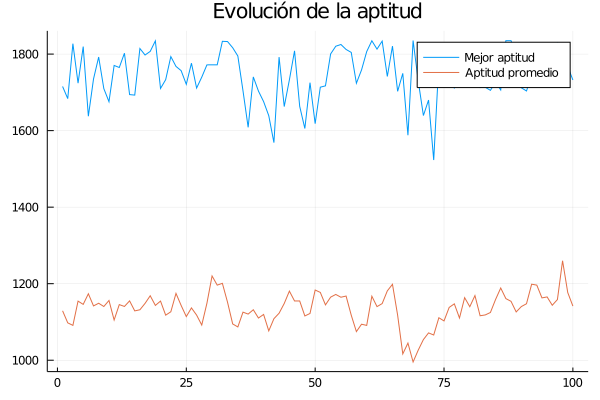

In [28]:
k2 = Sga(100, 0.5, 0.1)
data = collect_data(k2, 100)
plot(data, title="Evolución de la aptitud", label=["Mejor aptitud" "Aptitud promedio"])

* Grafique en el plano $x, y$ los individuos de las generaciones 1, 10, 50, 100.

In [16]:
function plot_evolution(sga::Sga, gens::Int, plotting_gens::Array{Int, 1})::Array{Any, 1}
    plots = []
    best_apt = []
    avg_apt = []
    for i in 1:gens
        if i in plotting_gens
            coords = to_coords.(sga.pop)
            x, y = ([s(c[1]) for c in coords], [s(c[2]) for c in coords])
            p = plot(x, y, seriestype = :scatter, title="Población en generación $i", label="")
            push!(plots, p)
        end
        sga.pop = replacement(sga)
    end
    return plots
end

plot_evolution (generic function with 1 method)

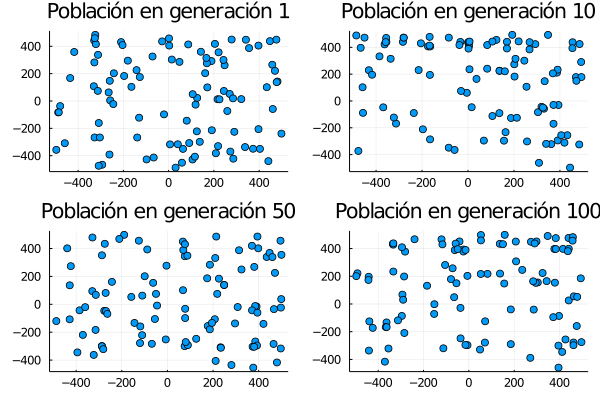

In [17]:
k3 = Sga(100, 0.5, 0.1)
p = plot_evolution(k3, 100, [1, 10, 50, 100])
plot(p[1], p[2], p[3], p[4])

## Exploración

Genere otros experimentos cambiando la tasa de recombinacioń y de mutación. Grafique los puntos anteriores para las diferentes configuraciones. ¿Con qué parámetros se encuentra más rápido el máximo global?